In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import math

## Load Data

**FER 2013 Dataset**
> The major dataset we used for model building is the Facial Expression Recognition 2013 (FER-2013) dataset with 28709 training images, 3589 validation images, and 3589 testing cases. Since this dataset is classic data for facial recognition, we’re able to explore pre-existing models such as VGG, Res-Net, and Inception, as well as build CNN architecture from scratch to explore the classification techniques.

>The dataset consists of 35,887 grayscale, 48 x 48 sized face images with various emotions. The image data is split by space character as a list, resizing to dimension (48, 48) and the dimension of the channel is also expanded for each image for model fitting. Image label with 7 emotion categories is converted into dummy variables. The data pre-processing process is written as a pipeline and stored on GitHub.


In [3]:
# Load data
df = pd.read_csv('/content/gdrive/My Drive/Data_For_Colab/IDS_705_Final_Project/fer2013.csv')

In [4]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Data Visualization

**Insights Summary**
> Imbalanced Categories (How to Process?)  
> Greyscales: center data by substrating the mean from every features  
> The piexi data used the raw pixel values (which eange from [0,255] -- perform normalization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
emotion_cat = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
emotion_y = [emotion_cat[i] for i in df['emotion']]

In [ ]:
Counter(emotion_y)

Counter({'anger': 4953,
         'disgust': 547,
         'fear': 5121,
         'happiness': 8989,
         'neutral': 6198,
         'sadness': 6077,
         'surprise': 4002})

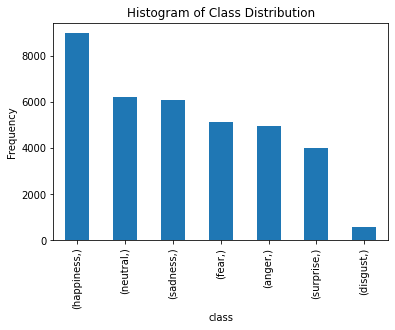

In [ ]:
pd.DataFrame(emotion_y).value_counts().plot(kind='bar');
plt.title('Histogram of Class Distribution')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

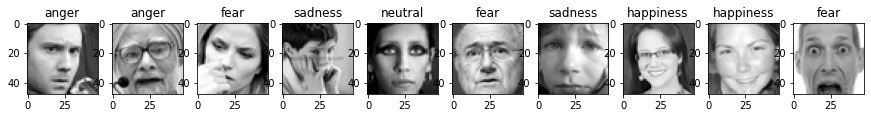

In [ ]:
plt.figure(figsize=(15,2))
X = df['pixels'][:10]
y = emotion_y[:10]
X = X.apply(lambda x: np.array(x.split(' ')).astype('float32'))

for index, (image, label) in enumerate(zip(X, y)):
    plt.subplot(1, 10, index + 1)
    plt.imshow(np.reshape(image, (48,48)), cmap=plt.cm.gray)
    plt.title(y[index])

## Data Processing

#### a. Train-Test Split

In [7]:
# Test-Training Split 
X_train = df[df['Usage'] == 'Training']['pixels']
X_val = df[df['Usage'] == 'PrivateTest']['pixels']
X_test = df[df['Usage'] == 'PublicTest']['pixels']

In [8]:
y_train = df[df['Usage'] == 'Training']['emotion']
y_val = df[df['Usage'] == 'PrivateTest']['emotion']
y_test = df[df['Usage'] == 'PublicTest']['emotion']

In [ ]:
y_train.shape

(28709,)

In [ ]:
y_test.shape

(3589,)

#### b. Reshape Pixel Value

In [9]:
#getting features for training
def reshape(data):
    X = []
    for xseq in data:      
        xx = [int(xp) for xp in xseq.split(' ')]
        xx = np.asarray(xx).reshape(48, 48)
        X.append(xx.astype('float32'))
    X = np.asarray(X)
    # Add the color channel
    X = np.expand_dims(X, -1)
    return X

In [10]:
X_train = reshape(X_train)
X_val = reshape(X_val)
X_test = reshape(X_test)

In [11]:
X_train.shape

(28709, 48, 48, 1)

#### c. Normalize, Center, Standardlize Image Pixels
- Center image data by substracting the mean from every feature (single channel in this case)  
- Normalize features to the range [-1,1]
- The scaled piexel values will have a zero mean and unit variance
- Reference: https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
- Why: After normalization, less sensitive to small changes in weights; easier to optimize

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# summarize pixel values
print('Train', X_train.min(), X_train.max(), X_train.mean(), X_train.std())
print('Val', X_val.min(), X_val.max(), X_val.mean(), X_val.std())
print('Test', X_test.min(), X_test.max(), X_test.mean(), X_test.std())

Train 0.0 255.0 129.47415 65.02729
Val 0.0 255.0 129.08296 65.35152
Test 0.0 255.0 128.98097 65.00601


In [ ]:
# create and configure the data generator
# only calculating the stats based on training data
datagen = ImageDataGenerator(rescale= 1/127, featurewise_center=True)
datagen.fit(X_train)

In [ ]:
# check for mean
iterator = datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False)
# get a batch
batchX, batchy = iterator.next()
# mean pixel value in the batch
print(batchX.shape, batchX.mean(), batchX.min(), batchX.max(), batchX.std())

(28709, 48, 48, 1) 7.2724123e-07 -1.0194823 0.98839176 0.5120258


In [ ]:
# center & normalization manually
# mean = X_train.mean()
# sd = X_train.std()
# X_train = (X_train - mean)/127

#### d. Image Augmentation Visulization

In [25]:
# example of horizontal shift image augmentation
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

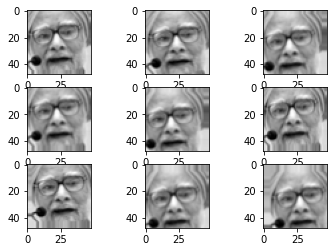

In [39]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)

sample = expand_dims(X_train[1], 0)
# prepare iterator
it = datagen.flow(sample, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(np.reshape(image, (48,48)), cmap=plt.cm.gray)
# show the figure
pyplot.show()

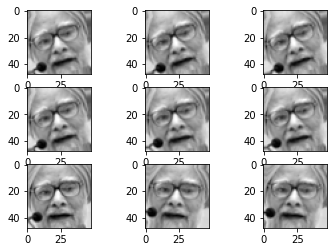

In [46]:
datagen = ImageDataGenerator(rotation_range = 15)
# prepare iterator
it = datagen.flow(sample, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(np.reshape(image, (48,48)), cmap=plt.cm.gray)
# show the figure
pyplot.show()

#### e. Encoding Emotion Labels

In [ ]:
from keras.utils import np_utils

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [ ]:
y_train.shape

(28709, 7)

## Modeling

In [ ]:
# Initialize Weight

### a. BaseLine Model

### b. Transfer Model

#### VGG-16

In [ ]:
from keras.applications import VGG16
from keras.layers import *

In [ ]:
# Expand Image Dimension To Fit
IMG_SIZE = 48
X_train_VGG = Concatenate()([X_train, X_train, X_train])
X_train_VGG.shape

TensorShape([28709, 48, 48, 3])

In [ ]:
# Initialization
EPOCHS = 64
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
# add early stopping
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [
    early_stopping
]

In [ ]:
vgg_notop = VGG16(include_top=False, input_shape=(48, 48, 3), pooling='avg')
print(vgg_notop.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
vgg_notop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_notop

In [ ]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# NOT ORGANIZED

**Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Model A (Baseline) -- Without Early Stopping

> Overfit



In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [ ]:
# Create the model
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
# compile the model

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
# Train the model

history = model.fit(np.array(X_train), np.array(y_train),
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data= (X_val, y_val))

Epoch 1/100
449/449 [==============================] - 55s 46ms/step - loss: 2.3280 - accuracy: 0.1960 - val_loss: 1.8362 - val_accuracy: 0.2452
Epoch 2/100
449/449 [==============================] - 20s 44ms/step - loss: 1.8504 - accuracy: 0.2463 - val_loss: 1.8142 - val_accuracy: 0.2446
Epoch 3/100
449/449 [==============================] - 20s 45ms/step - loss: 1.8193 - accuracy: 0.2513 - val_loss: 1.7867 - val_accuracy: 0.2658
Epoch 4/100
449/449 [==============================] - 20s 45ms/step - loss: 1.7797 - accuracy: 0.2747 - val_loss: 1.7099 - val_accuracy: 0.3062
Epoch 5/100
449/449 [==============================] - 21s 46ms/step - loss: 1.6814 - accuracy: 0.3166 - val_loss: 1.6264 - val_accuracy: 0.3327
Epoch 6/100
449/449 [==============================] - 21s 46ms/step - loss: 1.5923 - accuracy: 0.3694 - val_loss: 1.5565 - val_accuracy: 0.3873
Epoch 7/100
449/449 [==============================] - 20s 46ms/step - loss: 1.5074 - accuracy: 0.4058 - val_loss: 1.4281 - val_ac

In [ ]:
!pip install pyyaml h5py 

In [ ]:
#saving the model
import os

os.chdir("//content/gdrive/My Drive/saved_model/")
model.save("modelA_1.h5")

FileNotFoundError: ignored

Model Evaluation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

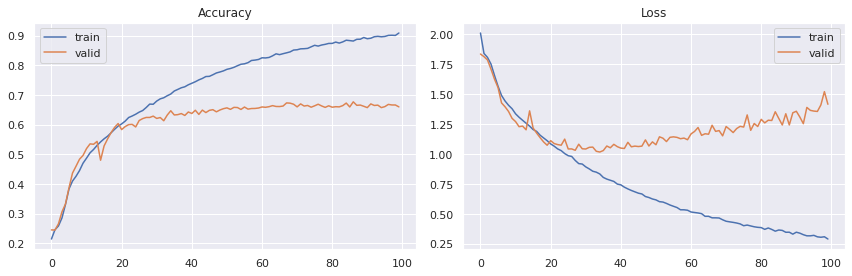

In [ ]:
import matplotlib.pyplot as plt

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       491
           1       0.73      0.58      0.65        55
           2       0.55      0.46      0.50       528
           3       0.91      0.84      0.87       879
           4       0.53      0.48      0.51       594
           5       0.77      0.82      0.79       416
           6       0.54      0.71      0.61       626

    accuracy                           0.66      3589
   macro avg       0.66      0.64      0.65      3589
weighted avg       0.67      0.66      0.66      3589

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       467
           1       0.73      0.54      0.62        56
           2       0.51      0.45      0.48       496
           3       0.88      0.81      0.84       895
           4       0.56      0.48      0.52       653
           5       0.76      0.85      0.80       415
           6       0.50 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


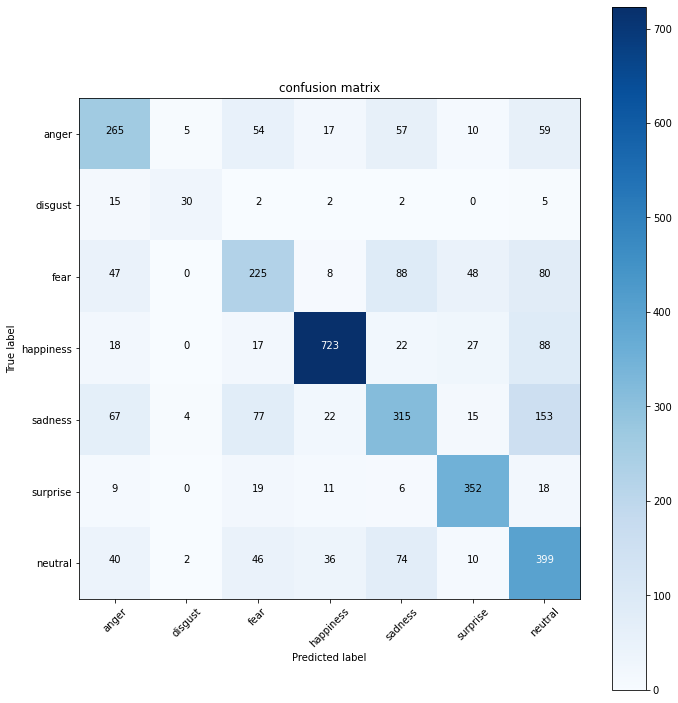

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict_classes(X_test)

plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(emotion))
plt.xticks(tick_marks, emotion, rotation=45)
plt.yticks(tick_marks, emotion)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

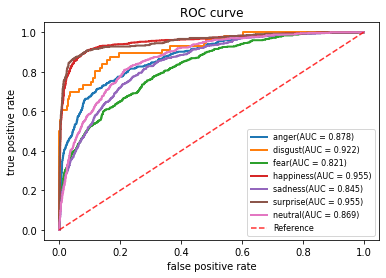

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

y_test_pred = model.predict(X_test)


fig, ax = plt.subplots()
# roc curve
fpr = dict()
tpr = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_test_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_test_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label= str(emotion[i]) + '(AUC = %0.3f)' % (auc))


ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='r', label='Reference', alpha=.8)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best", fontsize = 8)
plt.title("ROC curve")
plt.show()

plt.savefig('roc_curve_modelA1.png')

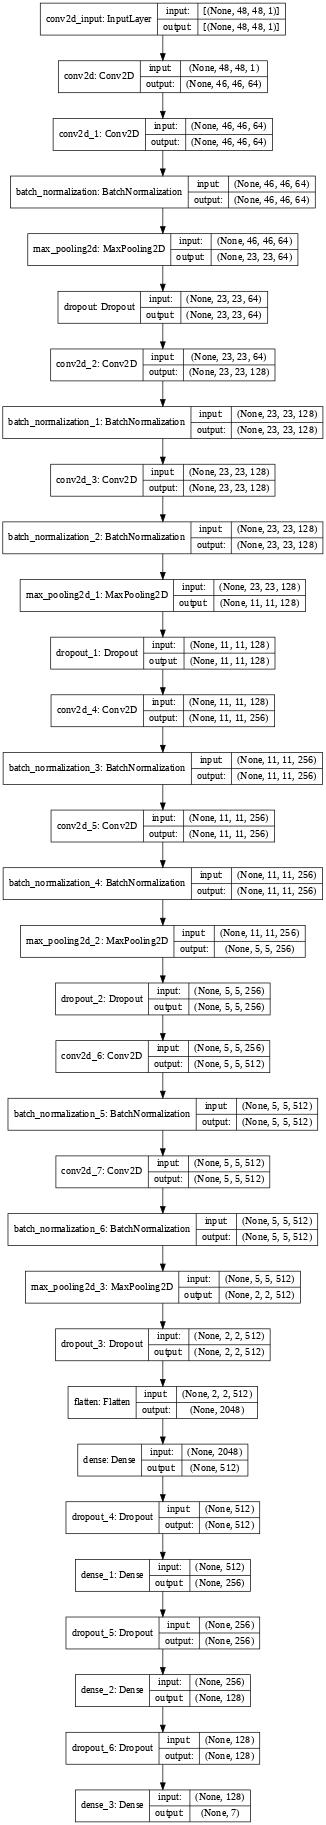

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')



ModelA - Improvement added early stopping to prevent overfit

In [ ]:
modelA_2 = Sequential()

modelA_2.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
modelA_2.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_2.add(Dropout(0.5))

modelA_2.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_2.add(Dropout(0.5))

modelA_2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_2.add(Dropout(0.5))

modelA_2.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_2.add(BatchNormalization())
modelA_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_2.add(Dropout(0.5))

modelA_2.add(Flatten())

modelA_2.add(Dense(2*2*2*num_features, activation='relu'))
modelA_2.add(Dropout(0.4))
modelA_2.add(Dense(2*2*num_features, activation='relu'))
modelA_2.add(Dropout(0.4))
modelA_2.add(Dense(2*num_features, activation='relu'))
modelA_2.add(Dropout(0.5))

modelA_2.add(Dense(num_labels, activation='softmax'))

In [ ]:
# compile the model

modelA_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
# add early stopping
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [
    early_stopping
]

In [ ]:
# training the model

history_2 = modelA_2.fit(np.array(X_train), np.array(y_train),
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      callbacks = callbacks,
                      validation_data= (X_val, y_val))

Epoch 1/100
449/449 [==============================] - 22s 47ms/step - loss: 2.3952 - accuracy: 0.1943 - val_loss: 1.8173 - val_accuracy: 0.2449
Epoch 2/100
449/449 [==============================] - 21s 46ms/step - loss: 1.8386 - accuracy: 0.2410 - val_loss: 1.8437 - val_accuracy: 0.2527
Epoch 3/100
449/449 [==============================] - 20s 45ms/step - loss: 1.7904 - accuracy: 0.2726 - val_loss: 1.7056 - val_accuracy: 0.2942
Epoch 4/100
449/449 [==============================] - 20s 45ms/step - loss: 1.7280 - accuracy: 0.2996 - val_loss: 1.9837 - val_accuracy: 0.2513
Epoch 5/100
449/449 [==============================] - 21s 46ms/step - loss: 1.6055 - accuracy: 0.3680 - val_loss: 1.5004 - val_accuracy: 0.4018
Epoch 6/100
449/449 [==============================] - 20s 46ms/step - loss: 1.5260 - accuracy: 0.4041 - val_loss: 1.4609 - val_accuracy: 0.4377
Epoch 7/100
449/449 [==============================] - 20s 45ms/step - loss: 1.4723 - accuracy: 0.4265 - val_loss: 1.3977 - val_ac

In [ ]:
#saving the model
os.chdir("//content/gdrive/My Drive/saved_model/")
modelA_2.save("modelA2.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

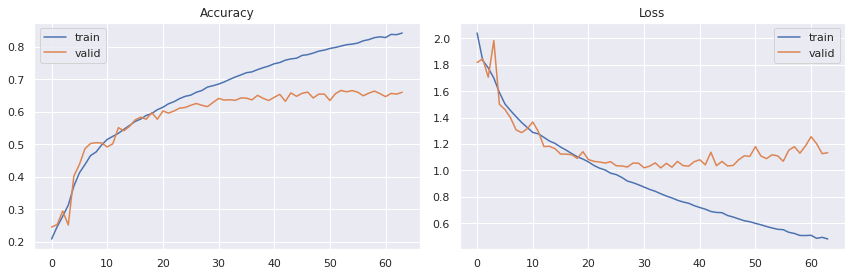

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history_2.epoch, history_2.history['accuracy'], label='train')
sns.lineplot(history_2.epoch, history_2.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history_2.epoch, history_2.history['loss'], label='train')
sns.lineplot(history_2.epoch, history_2.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

os.chdir("//content/gdrive/My Drive/saved_model/")
plt.savefig('epoch_history_dcnn_2.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_val_pred_2 = modelA_2.predict(X_val)
y_test_pred_2 = modelA_2.predict(X_test)

print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_val_pred_2, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred_2, axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57       491
           1       0.71      0.64      0.67        55
           2       0.56      0.43      0.49       528
           3       0.84      0.88      0.86       879
           4       0.54      0.54      0.54       594
           5       0.74      0.82      0.78       416
           6       0.57      0.72      0.63       626

    accuracy                           0.67      3589
   macro avg       0.66      0.65      0.65      3589
weighted avg       0.66      0.67      0.66      3589

              precision    recall  f1-score   support

           0       0.61      0.46      0.52       467
           1       0.74      0.62      0.68        56
           2       0.48      0.37      0.42       496
           3       0.83      0.85      0.84       895
           4       0.54      0.52      0.53       653
           5       0.75      0.82      0.78       415
           6       0.52 

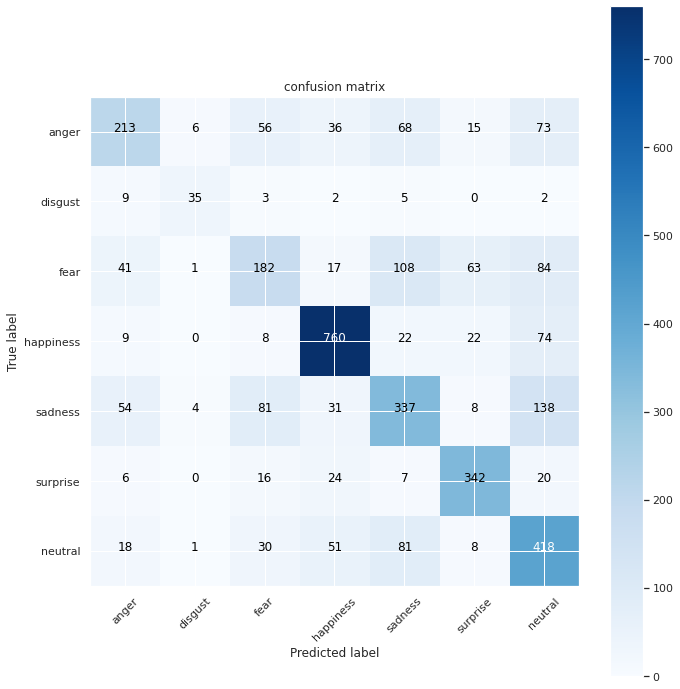

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred_2, axis=1))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(emotion))
plt.xticks(tick_marks, emotion, rotation=45)
plt.yticks(tick_marks, emotion)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

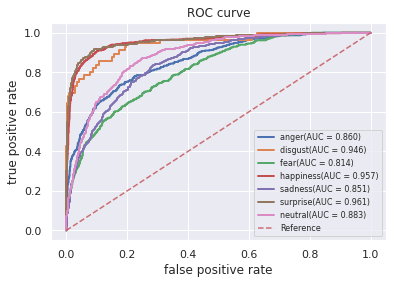

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

fig, ax = plt.subplots()
# roc curve
fpr = dict()
tpr = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_test_pred_2[:, i])
    auc = roc_auc_score(y_test[:, i], y_test_pred_2[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label= str(emotion[i]) + '(AUC = %0.3f)' % (auc))


ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='r', label='Reference', alpha=.8)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best", fontsize = 8)
plt.title("ROC curve")
plt.show()

plt.savefig('roc_curve_modelA2.png')

Improvement -- Add Image augmentation

In [ ]:
modelA_3 = Sequential()

modelA_3.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
modelA_3.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_3.add(Dropout(0.5))

modelA_3.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_3.add(Dropout(0.5))

modelA_3.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_3.add(Dropout(0.5))

modelA_3.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelA_3.add(BatchNormalization())
modelA_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelA_3.add(Dropout(0.5))

modelA_3.add(Flatten())

modelA_3.add(Dense(2*2*2*num_features, activation='relu'))
modelA_3.add(Dropout(0.4))
modelA_3.add(Dense(2*2*num_features, activation='relu'))
modelA_3.add(Dropout(0.4))
modelA_3.add(Dense(2*num_features, activation='relu'))
modelA_3.add(Dropout(0.5))

modelA_3.add(Dense(num_labels, activation='softmax'))

In [ ]:
# compile the model

modelA_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_gen.fit(X_train)

In [ ]:
history_3 = modelA_3.fit(train_gen.flow(X_train, y_train, batch_size=32),
                      batch_size=32,
                      epochs=epochs,
                      verbose=1,
                      steps_per_epoch = len(X_train) / 32,
                      callbacks = callbacks,
                      validation_data= (X_val, y_val))

Epoch 1/100
897/897 [==============================] - 28s 29ms/step - loss: 2.2854 - accuracy: 0.2050 - val_loss: 1.8242 - val_accuracy: 0.2449
Epoch 2/100
897/897 [==============================] - 25s 28ms/step - loss: 1.8434 - accuracy: 0.2501 - val_loss: 1.8277 - val_accuracy: 0.2449
Epoch 3/100
897/897 [==============================] - 25s 28ms/step - loss: 1.8238 - accuracy: 0.2475 - val_loss: 1.8138 - val_accuracy: 0.2399
Epoch 4/100
897/897 [==============================] - 25s 28ms/step - loss: 1.8154 - accuracy: 0.2463 - val_loss: 1.8134 - val_accuracy: 0.2449
Epoch 5/100
897/897 [==============================] - 25s 28ms/step - loss: 1.7970 - accuracy: 0.2564 - val_loss: 1.7969 - val_accuracy: 0.2499
Epoch 6/100
897/897 [==============================] - 25s 28ms/step - loss: 1.7992 - accuracy: 0.2526 - val_loss: 1.8347 - val_accuracy: 0.2449
Epoch 7/100
897/897 [==============================] - 25s 28ms/step - loss: 1.7764 - accuracy: 0.2686 - val_loss: 1.8301 - val_ac

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

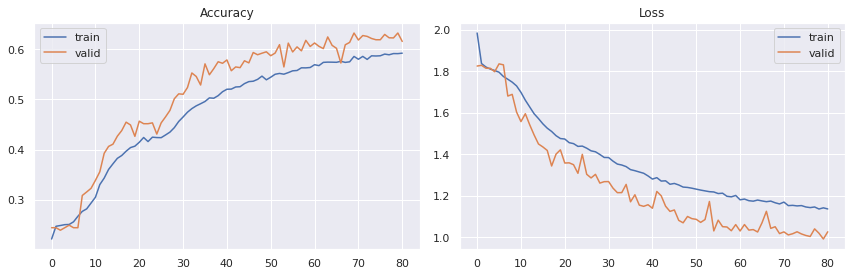

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history_3.epoch, history_3.history['accuracy'], label='train')
sns.lineplot(history_3.epoch, history_3.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history_3.epoch, history_3.history['loss'], label='train')
sns.lineplot(history_3.epoch, history_3.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn_3.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_val_pred_3 = modelA_3.predict(X_val)
y_test_pred_3 = modelA_3.predict(X_test)

print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_val_pred_3, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred_3, axis=1)))

              precision    recall  f1-score   support

           0       0.53      0.59      0.56       491
           1       0.00      0.00      0.00        55
           2       0.50      0.17      0.25       528
           3       0.84      0.91      0.87       879
           4       0.46      0.59      0.52       594
           5       0.72      0.75      0.73       416
           6       0.60      0.68      0.64       626

    accuracy                           0.63      3589
   macro avg       0.52      0.53      0.51      3589
weighted avg       0.61      0.63      0.61      3589

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       467
           1       0.00      0.00      0.00        56
           2       0.55      0.15      0.23       496
           3       0.82      0.89      0.85       895
           4       0.47      0.58      0.52       653
           5       0.70      0.78      0.74       415
           6       0.54 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#saving the model
modelA_3.save("modelA_3.h5")

Evaluation Using Testing Data (Accuracy & Speed)

In [ ]:
new_model = tf.keras.models.load_model('model.h5')

OSError: ignored

In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored